In [ ]:
import numpy as np
import random
from keras import callbacks
from keras.callbacks import History
from keras.layers.recurrent import LSTM
from keras.layers.embeddings import Embedding
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import utils
import string
from typing import List, Tuple
import re

In [ ]:
import pandas as pd
from pandas import DataFrame


def load_lyrics(csv_path: str) -> DataFrame:
    df = pd.read_csv(csv_path, sep='\n', header=None)
    res = df.iloc[:, 0].str.rstrip(r'&, ').str.extract(r'([^,]+),([^,]+),(.+)')
    res.columns = ['artist', 'title', 'lyrics']
    return res


In [ ]:
def create_x_y(songs, tokenize, total_words, max_len) -> Tuple[np.ndarray, np.ndarray]:
    input_sequences = []
    for line in songs:
        token_list = tokenize.texts_to_sequences([line])[0]
        for i in range(1, len(token_list)):
            n_gram_sequence = token_list[:i + 1]
            input_sequences.append(n_gram_sequence)
    print(input_sequences[:10])
    max_sequence_len = max([len(x) for x in input_sequences])
    # input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
    input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_len, padding='pre'))
    x_train = input_sequences[:, :-1]
    y_train = input_sequences[:, -1]
    y_train = utils.to_categorical(y_train, num_classes=total_words)
    return x_train, y_train

def create_x_y_train(songs, tokenize, total_words) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    
    random.shuffle(songs)
    val_songs = songs[:120]
    train_songs = songs[120:]
    # input_sequences = []
    # for line in songs:
    #     token_list = tokenize.texts_to_sequences([line])[0]
    #     for i in range(1, len(token_list)):
    #         n_gram_sequence = token_list[:i + 1]
    #         input_sequences.append(n_gram_sequence)
    # print(input_sequences[:10])
    # max_sequence_len = max([len(x) for x in input_sequences])
    # # input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
    # input_sequences = np.array(pad_sequences(input_sequences, maxlen=100, padding='pre'))
    # x_train = input_sequences[:, :-1]
    # y_train = input_sequences[:, -1]
    # y_train = utils.to_categorical(y_train, num_classes=total_words)
    max_len = 10
    x_t, y_t = create_x_y(train_songs, tokenize, total_words, max_len)
    x_v, y_v = create_x_y(val_songs, tokenize, total_words, max_len)
    return x_t, y_t, x_v, y_v, max_len


import pandas as pd
from pandas import DataFrame


def load_lyrics(csv_path: str) -> DataFrame:
    df = pd.read_csv(csv_path, sep='\n', header=None)
    res = df.iloc[:, 0].str.rstrip(r'&, ').str.extract(r'([^,]+),([^,]+),(.+)')
    res.columns = ['artist', 'title', 'lyrics']
    return res

def load_songs(path) -> List[str]:
    df = load_lyrics(path)
    songs = []
    for song in list(df['lyrics']):
        song += " EOF"
        # remove '(*)'
        modified_song = re.sub(r"\([^()]*\)", "", song)
        modified_song = modified_song.replace("chorus", "").lower()
        # modified_song = modified_song.replace("chorus", "").replace("&", "silencio").lower()
        # modified_song = modified_song.replace("&", "silencio").lower()
        regex = re.compile('[%s]' % re.escape(string.punctuation))
        modified_song = regex.sub('', modified_song)
        songs.append(modified_song)
    songs.pop(305)
    return songs

def remove_words(words: List[str], songs):
    resulting_songs = []
    for song in songs:
        result = song
        for word in words:
            result = result.replace(word, '')
        resulting_songs.append(result)
    return resulting_songs

In [27]:
class LyricsGenerator(object):

    def __init__(self, embedding_dim: int, vocab_size: int, input_size: int, embedding_matrix: np.ndarray):
        embedding_layer = Embedding(
            vocab_size,
            embedding_dim,
            input_length=input_size,
            weights=[embedding_matrix],
            # embeddings_initializer=initializers.Constant(embedding_matrix),
            trainable=False,
        )

        self.model = Sequential()
        self.model.add(embedding_layer)
        self.model.add(LSTM(units=embedding_dim))
        self.model.add(Dropout(0.2))
        self.model.add(Dense(units=vocab_size, activation='softmax'))
        self.model.compile(optimizer='adam', loss='categorical_crossentropy')
        self.model.summary()

    def fit(self, x, y, hyper_parameters):
        callback = callbacks.EarlyStopping(monitor='loss', patience=3)
        callback2 = callbacks.LearningRateScheduler(self._lr_scheduler)
        # callback3 = callbacks.ModelCheckpoint('lyrics_model.h5', save_best_only=True, monitor='val_loss', mode='min')
        # callback = callbacks.EarlyStopping(monitor='val_accuracy', mode='max', min_delta=1)
        # history = self.model.fit(x, y, epochs=100, verbose=1)
        history = self.model.fit(x, y, batch_size=hyper_parameters['batch_size'], epochs=hyper_parameters['epochs'],
                                 callbacks=[callback],
                                 # callbacks=[callback, callback2],
                                 verbose=1, validation_split=hyper_parameters['validation_split'],
                                 validation_data=hyper_parameters['val_data'])
        self.model.save('lyrics_model.h5')
        
        return history

    def _lr_scheduler(self, epoch, lr):
        return 0.95 * lr

    # to get a picture of loss progress.
    def plot_metric(self, history: History, metric: str = 'loss') -> None:
        import matplotlib.pyplot as plt
        train_metrics = history.history[metric]
        val_metrics = history.history['val_'+metric]
        epochs = range(1, len(train_metrics) + 1)
        plt.plot(epochs, train_metrics)
        plt.plot(epochs, val_metrics)
        plt.title('Training and validation '+ metric)
        plt.xlabel("Epochs")
        plt.ylabel(metric)
        plt.legend(["train_"+metric, 'val_'+metric])
        plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
embedding_matrixs =  np.load("/content/drive/MyDrive/DL/Assignment_3/Lyrics/embedding_matrix_glove.npy")
embedding_matrixs.shape

(7527, 300)

In [ ]:
songs = load_songs('/content/drive/MyDrive/DL/Assignment_3/Lyrics/lyrics_train_set.csv')

# Data preprocessing
tokenize = Tokenizer()
tokenize.fit_on_texts(songs)
total_words = len(tokenize.word_index) + 1

In [ ]:
# import tensorflow as tf
# import random
# tf.random.set_seed(1)
# random.seed(2)
# np.random.seed(3)
import json
non_words_dict = json.load(open('/content/drive/MyDrive/DL/Assignment_3/Lyrics/non_words.json', "r"))
non_words_list = non_words_dict["non existing words"]
cleaned_songs = remove_words(non_words_list, songs)
print(len(cleaned_songs))


599


In [ ]:
# # Data preprocessing
# tokenize = Tokenizer()
# tokenize.fit_on_texts(cleaned_songs)
# total_words = len(tokenize.word_index) + 1

embedding_dim = 300
x_train, y_train, x_val, y_val, max_sequence_len = create_x_y_train(cleaned_songs, tokenize, total_words)

[[901, 37], [901, 37, 2], [901, 37, 2, 1005], [901, 37, 2, 1005, 781], [901, 37, 2, 1005, 781, 652], [901, 37, 2, 1005, 781, 652, 901], [901, 37, 2, 1005, 781, 652, 901, 37], [901, 37, 2, 1005, 781, 652, 901, 37, 2], [901, 37, 2, 1005, 781, 652, 901, 37, 2, 1005], [901, 37, 2, 1005, 781, 652, 901, 37, 2, 1005, 337]]
[[32, 3], [32, 3, 53], [32, 3, 53, 349], [32, 3, 53, 349, 3], [32, 3, 53, 349, 3, 47], [32, 3, 53, 349, 3, 47, 494], [32, 3, 53, 349, 3, 47, 494, 935], [32, 3, 53, 349, 3, 47, 494, 935, 5], [32, 3, 53, 349, 3, 47, 494, 935, 5, 1193], [32, 3, 53, 349, 3, 47, 494, 935, 5, 1193, 17]]


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 9, 300)            2258100   
_________________________________________________________________
lstm_6 (LSTM)                (None, 300)               721200    
_________________________________________________________________
dropout_6 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 7527)              2265627   
Total params: 5,244,927
Trainable params: 2,986,827
Non-trainable params: 2,258,100
_________________________________________________________________
Epoch 1/30
240/240 [==============================] - 7s 25ms/step - loss: 6.6803 - val_loss: 6.2808
Epoch 2/30
240/240 [==============================] - 5s 22ms/step - loss: 5.8332 - val_loss: 6.0761
Epoch 3/30
240/240 [============

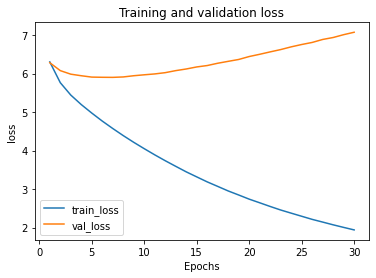

In [28]:
# Train model

parameters = {
    'batch_size' : 512 ,
    'validation_split' : None ,
    'epochs' : 50 ,
    'val_data' :  (x_val, y_val)
}
lyrics_generator = LyricsGenerator(embedding_dim, total_words, x_train.shape[1], embedding_matrixs)
h = lyrics_generator.fit(x_train, y_train, parameters)
lyrics_generator.plot_metric(h)

In [29]:
# print(generate_text('forgive' , "eof" , lyrics_generator , max_sequence_len, total_words))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


forgive up it think wanna time dont the times here oh to without to tell my youre he his cant the boys it be she belongs and back the cause be to deep a i by it although oh if to look oh cant behind the go a store been before a nice hello here meaning love got when to was lady feel all that the too under that remember my last love get a all your horse with me got its war friends turn a thing find could needs me im its cause be to yeah a hand and intergalactic ive his stand it sense no opened if of think if of of endless know again it wheel bop the ive his eof


Epoch 1/20
958/958 [==============================] - 8s 8ms/step - loss: 2.2473 - val_loss: 7.1398
Epoch 2/20
958/958 [==============================] - 8s 8ms/step - loss: 2.0103 - val_loss: 7.2870
Epoch 3/20
958/958 [==============================] - 8s 8ms/step - loss: 1.8893 - val_loss: 7.4088
Epoch 4/20
958/958 [==============================] - 8s 8ms/step - loss: 1.7957 - val_loss: 7.5550
Epoch 5/20
958/958 [==============================] - 8s 8ms/step - loss: 1.7173 - val_loss: 7.6554
Epoch 6/20
958/958 [==============================] - 8s 8ms/step - loss: 1.6448 - val_loss: 7.7891
Epoch 7/20
958/958 [==============================] - 8s 8ms/step - loss: 1.5786 - val_loss: 7.8829
Epoch 8/20
958/958 [==============================] - 8s 8ms/step - loss: 1.5173 - val_loss: 8.0130
Epoch 9/20
958/958 [==============================] - 8s 8ms/step - loss: 1.4645 - val_loss: 8.1473
Epoch 10/20
958/958 [==============================] - 8s 8ms/step - loss: 1.4071 - val_loss: 8.1975

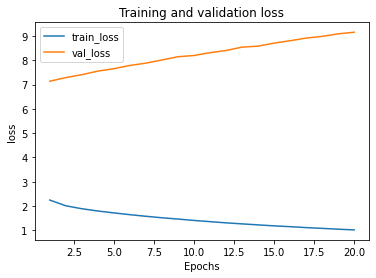

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


forgive my all got if the ive these girl the all the only to without night to my her got drums it wed out your fall oh anytime the pum will weve i out that that this boys another it with i falling no for me we come and to just me anytime the hair your should fought oh youre if the comin the i shit the guy eyes make the should be man falling see a have lick will in i tonight in in with where to hard and for the late its its girl dont thinking not space cant take my all life love love to was from my tell game it one light oh to all that the cause again how how know know know know dont never find if this again ooh help all could live to right youre with up im i listen in i take in can for side and i but down for the comes and why i youve i with lose find they part i all the through to i something and to waiting make of in not the lookin what me by a been been before they ooh i do say the two your all a found a loving here mean its he this listen and time cant because fly like be breeze a 

In [30]:
# parameters = {
#     'batch_size' : 512 ,
#     'validation_split' : None ,
#     'epochs' : 20 ,
#     'val_data' :  (x_val, y_val)
# }
# h = lyrics_generator.fit(x_train, y_train, parameters)
# lyrics_generator.plot_metric(h)
# print(generate_text('forgive' , "eof" , lyrics_generator , max_sequence_len, total_words))

In [ ]:
def generate_text(seed_text, eof, model, max_sequence_len, vocab_size):
    next_word = ""
    word_indices = np.arange(vocab_size) + 1
    while next_word != eof:
        token_list = tokenize.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predicted_proba = model.model.predict_proba(token_list, verbose=0)
        # print(predicted_proba.reshape((predicted_proba.shape[1])).shape)
        # sample the word index acording to predicted proba
        chosen_index = np.random.choice(word_indices ,1 ,replace=False, p=predicted_proba.reshape((predicted_proba.shape[1])))

        
        next_word = ""
        for word, index in tokenize.word_index.items():
            if index == chosen_index:     
                next_word = word
                # print(next_word)
                break
        seed_text += " " + next_word
    return seed_text

In [ ]:
print(generate_text('forgive' , "eof" , lyrics_generator , max_sequence_len, total_words))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


forgive lover its if i manic your o ba across i number bells and each in that ask do find three move to miss will he hurl and drank can money im its me be even naturally thats in up know di bad feel that anytime summer make think feel apart give my world ever way what about of help my tell your girls and to some waterloo cant the simon call need the should of im they warm like me leavin im he before icy can for the wondering are that know eof
